Written by: Omid G. Sani  
Last update: Feb 5, 2021  
GitHub link: https://github.com/ShanechiLab/PyPSID/blob/main/source/PSID/example/PSID_tutorial.ipynb  
Google Collab link: https://colab.research.google.com/drive/16LwTXi_XJnBUlnhH0QXpa86x7CoKH0kZ

# What is PSID?

PSID stands for preferential subspace identification, a method for dynamic modeling of time-series data, while priorotizing the dynamics shared with another time-series. 

For example, given signals $y_k$ (e.g. neural signals) and $z_k$ (e.g behavior), PSID learns a dynamic model for $y_k$ while prioritizing the dynamics that are relevant to $z_k$.

For the derivation and results in real neural data see the paper below.

**Publication:**

Omid G. Sani, Hamidreza Abbaspourazad, Yan T. Wong, Bijan Pesaran, Maryam M. Shanechi. *Modeling behaviorally relevant neural dynamics enabled by preferential subspace identification*. Nature Neuroscience 24, 140–149 (2021). https://doi.org/10.1038/s41593-020-00733-0

View-only full-text link: https://rdcu.be/b993t

Original preprint: https://doi.org/10.1101/808154

You can also find a summary of the paper in the following Twitter thread: https://twitter.com/MaryamShanechi/status/1325835609345122304

# Installing PSID
To use PSID, you can either get the source code from [the PSID Github repository](https://github.com/ShanechiLab/PSID), or install it in your Python environment using pip:

For this notebook, we will use the source repository.

# Using PSID
## Modeling data
To use PSID, you first need to import the library by running:
```
import psid
```
You can then use its main data modeling function as:
```
idSys = psid.PSID(y, z, nx, n1, i);
```
With the following arguments:
- `y` and `z`: Neural (e.g. LFP signal powers or spike counts) and behavioral data (e.g. joint angles, hand position, etc), respectively. Dimensions are: time x data dimension (this can be changed with an optional argument documented in the code).
- `nx`: the total dimension of the latent state in the model.
- `n1`: the number of latent state dimensions that are going to be dedicated to behaviorally relevant neural dynamics.
- `i`: the subspace horizon used for modeling. There is more on the choice of `i` later in this notebook, but numbers such as 5 or 10 are typically suitable values for `i`.

And the following output:
- `idSys`: an object containing all the learned model parameters ($A$, $C_y$, $C_z$, etc) and some prediction, etc methods. There is more on the model structure later in this notebook.

## Using the model for dimension reduction, state estimation, and decoding
For a learned PSID model `idSys` you can use the `predict` method to extract the latent state and prediction behavior and neural activity given any new neural data as:
```
zPred, yPred, xPred = idSys.predict(yTest)
```
With the argument:
- `yTest`: Neural activity `y` in the test data. Dimensions are: time x data dimension.

And outputs (all dimensions are time x data dimension):
- `zPred`: Prediction of behavior using past neural activity at each data point.
- `yPred`: Prediction of neural activity using past neural activity at each data point.
- `xPred`: The latent state extarcted at each data point.

We will next go through a complete example of using PSID in data.

# A complete example
In this example, we will use PSID to model some data. First, we import PSID and a few other useful tools from PSID and other libraries.

In [1]:
import argparse, sys, os
sys.path.insert(0, os.path.join('..', '..'))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

import psid
from psid.evaluation import evalPrediction
from psid.MatHelper import loadmat

Let's start by loading an example model:

In [2]:
# Load data
sample_model_path = os.path.join(os.path.dirname(psid.__file__), 'example', 'sample_model.mat')
                 
print('Loading example model from {}'.format(sample_model_path))
data = loadmat(sample_model_path)
# This is an example model (shown in Supplementary Fig. 1) with 
# (a) 2 behaviorally relevant latent states, 
# (b) 2 behaviorally irrelevant latent states, and 
# (c) 2 states that drive behavior but are not represented in neural activity

Loading example model from ../../psid/example/sample_model.mat


The PSID model looks like this:

$$ x_{k+1} = A x_k + w_k $$  

$$ y_k = C_y x_k + v_k $$  

$$ z_k = C_z x_k + \epsilon_k $$  

where $y_k \in \!R^{n_y}$ is the neural activity, $z_k \in \!R^{n_z}$ is the behavior, and $x_k \in \!R^{n_x}$ is the latent state the describes the dynamics in both. Importantly, PSID learns the model in the following format

$$
x_k = \begin{bmatrix}
x_k^{(1)} \\
x_k^{(2)}
\end{bmatrix}
$$

where the behaviorally relevant dimensions of latent state ($x_k^{(1)} \in \!R^{n_1}$), which are those that drive $z_k$, are separated from the other dimensions ($x_k^{(2)} \in \!R^{n_2}$ with $n_2=n_x-n_1$). There are many equivalent ways of writing a latent state model such as this one, but PSID learns the one that uses minimal number of dimensions to explain behavior as parsimoniously as possible (you can find the precise definition in the paper). Critically, PSID can learn this minimal model (with only $x_k^{(1)}$) without having to also learn the rest of the model (the $x_k^{(2)}$ part). This allows it to learn the model more accurately, while requiring fewer training samples.


Before going further, let's generate some sample data from this model.

In [3]:
# Generating some sample data from this model
np.random.seed(42) # For exact reproducibility

N = int(2e4)
trueSys = psid.LSSM(params=data['trueSys'])
y, x = trueSys.generateRealization(N)
z = (trueSys.Cz @ x.T).T

# Add some z dynamics that are not encoded in y (i.e. epsilon)
epsSys = psid.LSSM(params=data['epsSys'])
eps, _ = epsSys.generateRealization(N)
z += eps

allYData, allZData = y, z

Let's separate the data into training and test segments.

In [4]:
# Separate data into training and test data:
trainInds = np.arange(np.round(0.5*allYData.shape[0]), dtype=int)
testInds = np.arange(1+trainInds[-1], allYData.shape[0])
yTrain = allYData[trainInds, :]
yTest = allYData[testInds, :]
zTrain = allZData[trainInds, :]
zTest = allZData[testInds, :]

We will next use PSID in two ways:  
1. Learn a model with a low-dimensional latent state that only focuses on learning the behaviorally relevant neural dynamics (i.e. uses stage 1 of PSID only).  
2. Learn a model that also learns other neural dynamics (i.e. uses both stages of PSID)

We will then plot the learned models' eigenvalues (the eigenvalues of the $A$ matrix) to show that PSID learns the correct dynamics in each case.

First, let's learn a model with a 2 dimensional latent state that only learns the behaviorally relevant neural dyanmics. For this, we pass the arguments nx=2 and n1=2 to the PSID function:

In [5]:
## (Example 1) PSID can be used to dissociate and extract only the 
# behaviorally relevant latent states (with nx = n1 = 2)
idSys1 = psid.PSID(yTrain, zTrain, nx=2, n1=2, i=10)
# You can also use the time_first=False argument if time is the second dimension:
# idSys1 = psid.PSID(yTrain.T, zTrain.T, nx=2, n1=2, i=10, time_first=False) 

The PSID learning function returns an object (here idSys1) that contains the learned model parameters and can be used to extract the latent states and decode behavior in new data. To do this, we use the 'predict' method in the learned model:

In [6]:
# Predict behavior using the learned model
zTestPred1, yTestPred1, xTestPred1 = idSys1.predict(yTest)

# Compute CC of decoding
CC = evalPrediction(zTest, zTestPred1, 'CC')

# Predict behavior using the true model for comparison
zTestPredIdeal, yTestPredIdeal, xTestPredIdeal = trueSys.predict(yTest)
CCIdeal = evalPrediction(zTest, zTestPredIdeal, 'CC')

print('Behavior decoding CC:\n  PSID => {:.3g}, Ideal using true model => {:.3g}'.format(np.mean(CC), np.mean(CCIdeal)) )

Behavior decoding CC:
  PSID => 0.643, Ideal using true model => 0.643


We can see that the PSID model with a 2D latent state is as accurate in explaining behavior as the full model that has a 4D latent state. This is because the other 2 latent state dimensions in the true model explain dynamics that are exclusive to neural activity (i.e. are not behaviorally relevant).

Optionally, PSID can also learn other latent states beyond the behaviorally relevant ones. For this, we pass the arguments nx=4 and n1=2 to the PSID function:

In [7]:
## (Example 2) Optionally, PSID can additionally also learn the 
# behaviorally irrelevant latent states (with nx = 4, n1 = 2)
idSys2 = psid.PSID(yTrain, zTrain, nx=4, n1=2, i=10)

# In addition to ideal behavior decoding, this model will also have ideal neural self-prediction 
zTestPred2, yTestPred2, xTestPred2 = idSys2.predict(yTest)
yCC2 = evalPrediction(yTest, yTestPred2, 'CC')
yCCIdeal = evalPrediction(yTest, yTestPredIdeal, 'CC')
print('Neural self-prediction CC:\n  PSID => {:.3g}, Ideal using true model => {:.3g}'.format(np.mean(yCC2), np.mean(yCCIdeal)))

Neural self-prediction CC:
  PSID => 0.852, Ideal using true model => 0.852


We can see that in this case, the model learned by PSID (which now has a 4D latent state) is also as good as the true model in terms of explaining neural activity. 


Finally, we can plot the eigenvalues of the $A$ matrix in each of there learned models and compare them with the eigenvalues of the $A$ matrix in the true model to see the accurate learning of behaviorally relevant (and optionally the other) dynamics by PSID. 

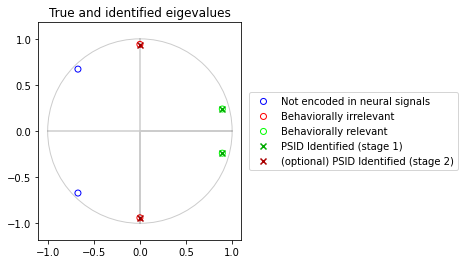

In [8]:
# #########################################
# Plot the true and identified eigenvalues    

# (Example 1) Eigenvalues when only learning behaviorally relevant states
idEigs1 = np.linalg.eig(idSys1.A)[0]

# (Example 2) Additional eigenvalues when also learning behaviorally irrelevant states
# The identified model is already in form of Eq. 4, with behaviorally irrelevant states 
# coming as the last 2 dimensions of the states in the identified model
idEigs2 = np.linalg.eig(idSys2.A[2:, 2:])[0]

relevantDims = trueSys.zDims - 1 # Dimensions that drive both behavior and neural activity
irrelevantDims = [x for x in np.arange(trueSys.state_dim, dtype=int) if x not in relevantDims] # Dimensions that only drive the neural activity
trueEigsRelevant = np.linalg.eig(trueSys.A[np.ix_(relevantDims, relevantDims)])[0]
trueEigsIrrelevant = np.linalg.eig(trueSys.A[np.ix_(irrelevantDims, irrelevantDims)])[0]
nonEncodedEigs = np.linalg.eig(data['epsSys']['a'])[0] # Eigenvalues for states that only drive behavior

fig = plt.figure(figsize=(8, 4))
axs = fig.subplots(1, 2)
axs[1].remove() 
ax = axs[0]
ax.axis('equal')
ax.add_patch( patches.Circle((0,0), radius=1, fill=False, color='black', alpha=0.2, ls='-') )
ax.plot([-1,1,0,0,0], [0,0,0,-1,1], color='black', alpha=0.2, ls='-')
ax.scatter(np.real(nonEncodedEigs), np.imag(nonEncodedEigs), marker='o', edgecolors='#0000ff', facecolors='none', label='Not encoded in neural signals')
ax.scatter(np.real(trueEigsIrrelevant), np.imag(trueEigsIrrelevant), marker='o', edgecolors='#ff0000', facecolors='none', label='Behaviorally irrelevant')
ax.scatter(np.real(trueEigsRelevant), np.imag(trueEigsRelevant), marker='o', edgecolors='#00ff00', facecolors='none', label='Behaviorally relevant')
ax.scatter(np.real(idEigs1), np.imag(idEigs1), marker='x', facecolors='#00aa00', label='PSID Identified (stage 1)')
ax.scatter(np.real(idEigs2), np.imag(idEigs2), marker='x', facecolors='#aa0000', label='(optional) PSID Identified (stage 2)')
ax.set_title('True and identified eigevalues')
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

# Using PSID with trial based data
You can also use PSID if the data is available in separate chunks, for example across many trials. To do this, simply pass a python list with the data in each chunk/trial as the argument to PSID. The trials don't need to have the same number of samples either. 

Below is an exmaple, where we break the same data as before in small chunks of random length, and then pass it to PSID.

In [9]:
## (Example 3) PSID can be used if data is available in discontinuous segments (e.g. different trials)
# In this case, y and z data segments must be provided as elements of a list
# Trials do not need to have the same number of samples
# Here, for example assume that trials start at every 1000 samples.
# And each each trial has a random length of 500 to 900 samples
trialStartInds = np.arange(0, allYData.shape[0]-1000, 1000)
trialDurRange = np.array([900, 990])
trialDur = np.random.randint(low=trialDurRange[0], high=1+trialDurRange[1], size=trialStartInds.shape)
trialInds = [trialStartInds[ti]+np.arange(trialDur[ti]) for ti in range(trialStartInds.size)] 
yTrials = [allYData[trialIndsThis, :] for trialIndsThis in trialInds] 
zTrials = [allZData[trialIndsThis, :] for trialIndsThis in trialInds] 

# Separate data into training and test data:
trainInds = np.arange(np.round(0.5*len(yTrials)), dtype=int)
testInds = np.arange(1+trainInds[-1], len(yTrials))
yTrain = [yTrials[ti] for ti in trainInds]
yTest = [yTrials[ti] for ti in testInds]
zTrain = [zTrials[ti] for ti in trainInds]
zTest = [zTrials[ti] for ti in testInds]

idSys3 = psid.PSID(yTrain, zTrain, nx=2, n1=2, i=10)

for ti in range(len(yTest)):
  zPredThis, yPredThis, xPredThis = idSys3.predict(yTest[ti])
  zPredThisIdeal, yPredThisIdeal, xPredThisIdeal = trueSys.predict(yTest[ti])
  if ti == 0:
    zTestA = zTest[ti]
    zPredA = zPredThis
    zPredIdealA = zPredThisIdeal
  else:
    zTestA = np.concatenate( (zTestA, zTest[ti]), axis=0)
    zPredA = np.concatenate( (zPredA, zPredThis), axis=0)
    zPredIdealA = np.concatenate( (zPredIdealA, zPredThisIdeal), axis=0)

CCTrialBased = evalPrediction(zTestA, zPredA, 'CC')
CCTrialBasedIdeal = evalPrediction(zTestA, zPredIdealA, 'CC')

print('Behavior decoding CC (trial-based learning/decoding):\n  PSID => {:.3g}, Ideal using true model = {:.3g}'.format(np.mean(CCTrialBased), np.mean(CCTrialBasedIdeal)) )

Behavior decoding CC (trial-based learning/decoding):
  PSID => 0.641, Ideal using true model = 0.641


# How to pick the state dimensions `nx` and `n1`?
`nx` determines the total dimension of the latent state and `n1` determines how many of those dimensions will be priorotizing the inclusion of behaviorally relevant neural dynamcis (i.e. will be extracted using stage 1 of PSID). So the values that you would select for these hyperparameters depend on the goal of modeling and on the data. Some examples use cases are:
- If you want to perform dimension reduction, `nx` will be your desired target dimension. For example, to reduce dimension to 2 to plot low-dimensional visualizations of neural activity, you would use `nx=2`. Now if you want to reduce dimension while preservising as much behaviorally relevant neural dynamics as possible, you would use `n1=nx`. 
- If you want to find the best fit to data overall, you can perform a grid search over values of `nx` and `n1` and pick the value that achieves the best performance metric in the training data. For exmaple, you could pick the `nx` and `n1` pair that achieves the best cross-validated behavior decoding in an inner-cross-validation within the training data.

# How to pick the horizon `i`?
The horizon `i` does not affect the model structure and only affects the intermediate linear algebra operations that PSID performs during the learning of the model. Nevertheless, different values of `i` may have different model learning performance. `i` needs to be at least 2, but also also determines the maximum `n1` and `nx` that can be used per: 
```
n1 <= nz * i
nx <= ny * i
```
So if you have a low dimensional y or z, you typically would choose larger values for `i`, and vice versa. It is also possible to select the best performing `i` via an inner cross-validation approach similar to `nx` and `n1` above.